# Introduction to Photometry

### Dora Föhring, University of Hawaii Institute for Astronomy

Aim: Demonstrate photometry on a series of bias and flat field corrected images of a Near Earth Asteroid.

## 0. Prerequisites

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
## make matplotlib appear in the notebook rather than in a new window
%matplotlib inline

### 0.1 Directory Set up

In [3]:
datadir = '/Users/dorafohring/Desktop/2016HO3/'
objname  = '2016HO3'

### 0.2 Display images

In [5]:
def plotfits(imno):
    img = fits.open(datadir+objname+'_{0:02d}.fits'.format(numb))[0].data

    f = plt.figure(figsize=(10,12))
    im = plt.imshow(img, cmap='hot')
    #im = plt.imshow(img[480:560, 460:540], cmap='hot')
    #plt.clim(1800, 2800)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.savefig("figure{0}.png".format(imno))
    plt.show()

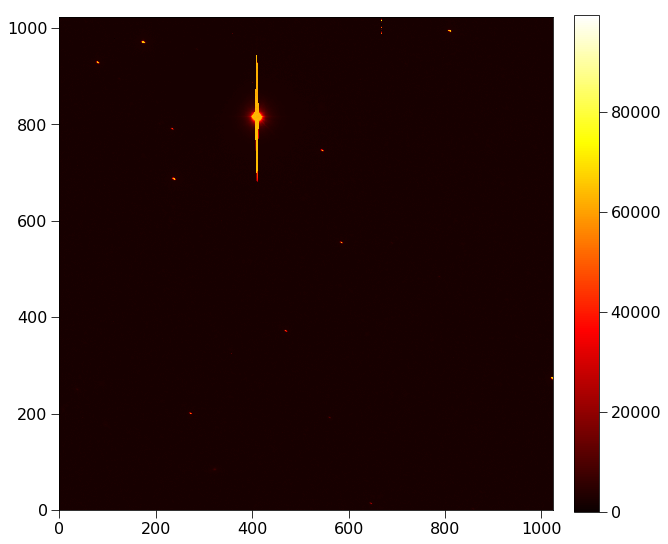

In [6]:
numb = 1 
plotfits(numb)

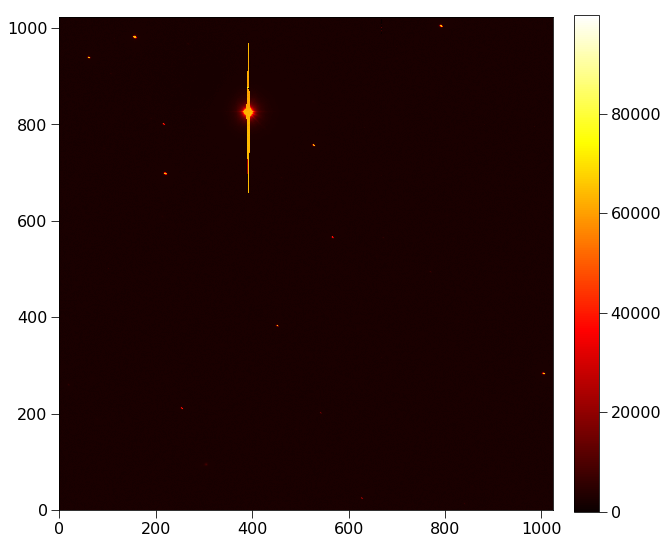

In [7]:
numb = 2
plotfits(numb)

## 1. Photometry set up

In [6]:
partimg = fits.open(datadir+objname+'_01.fits'.format(numb))[0].data[480:560, 460:540]

Define starting values

In [7]:
targcen = np.array([22,41])  ## target center
compcen = np.array([57,14])  ## comparison center

searchr = 12  ## search box size
ap_r = 2.5      ## aperture radius

sky_inner = 3
sky_outer = 5

### 1.1 Centroiding: Center of Mass

Calculate Center of Mass (CoM) defined as: $\bar{x} = \frac{\sum A_i x_i}{\sum A_i}$, $\bar{y} = \frac{\sum A_i y_i}{\sum A_i}$.

In [9]:
def cent_weight(n):
    """
    Assigns centroid weights
    """
    wghts=np.zeros((n),np.float)
    for i in range(n):
        wghts[i]=float(i-n/2)+0.5
    return wghts

def calc_CoM(psf, weights):
    """
    Finds Center of Mass of image
    """
    cent=np.zeros((2),np.float)
    temp=sum(sum(psf))
    cent[0]=sum(sum(psf)*weights)/temp
    cent[1]=sum(sum(psf.T)*weights)/temp
    return cent

In [ ]:
 * Gaussian centroiding routine. This measures the position of a peak
 * by cross-correlation with a gaussian of fixed width. This is fairly
 * robust in the presence of noise. It first searches for a maximum in the
 * cross-correlation, then runs a Newton-Raphson-like refinement to tweak the value.

Use centroiding algorithm to find the actual centers of the targe and comparison.

In [10]:
## Cut a box between search limits, centered around targcen
targbox = partimg[targcen[0]-searchr : targcen[0]+searchr, targcen[1]-searchr : targcen[1]+searchr]

weights = cent_weight(len(targbox))
tcenoffset = calc_com(targbox, weights)
print(tcenoffset)
tcenter = targcen + tcenoffset

[ 0.01001644  0.02049301]


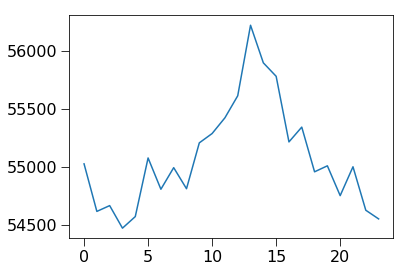

In [11]:
plt.plot(sum(targbox))
plt.show()

In [12]:
compbox = partimg[compcen[0]-searchr : compcen[0]+searchr, compcen[1]-searchr : compcen[1]+searchr]
compw = cent_weight(len(compbox))
ccenoffset = centroid(compbox,compw)
ccenter = compcen + ccenoffset

In [13]:
print(ccenoffset)

[-0.00071052  0.01133402]


In [14]:
compw

array([-11.5, -10.5,  -9.5,  -8.5,  -7.5,  -6.5,  -5.5,  -4.5,  -3.5,
        -2.5,  -1.5,  -0.5,   0.5,   1.5,   2.5,   3.5,   4.5,   5.5,
         6.5,   7.5,   8.5,   9.5,  10.5,  11.5])

Define new regions where the target and comparison are centered.

In [15]:
newtarg = partimg[int(round(tcenter[0]))-searchr : int(round(tcenter[0]))+searchr, int(round(tcenter[1]))-searchr : int(round(tcenter[1]))+searchr]
newcomp = partimg[int(round(ccenter[0]))-searchr : int(round(ccenter[0]))+searchr, int(round(tcenter[1]))-searchr : int(round(tcenter[1]))+searchr]

### 1.2 Aperture Photometry

#### Science Aperture

In [16]:
def circle(npix, r1):
    """
    Builds a circle
    """
    pup=np.zeros((npix,npix),np.int)
    for i in range(npix):
        for j in range(npix):
            r=np.sqrt((float(i-npix/2)+0.5)**2+(float(j-npix/2)+0.5)**2)
            if r<=r1:
                pup[i,j]=1
    return pup

#### Sky annulus

In [17]:
def annulus(npix, r_inner,r_outer=-1.):
    """
    Builds an annulus
    """
    pup=np.zeros((npix,npix),np.int)
    for i in range(npix):
        for j in range(npix):
            r=np.sqrt((float(i-npix/2)+0.5)**2+(float(j-npix/2)+0.5)**2)
            if ((r<=r_outer)&(r>=r_inner)):
                pup[i,j]=1
    return pup

#### Extract values from regions

Place mask on aperture slice.

In [18]:
targaper = circle(searchr*2, ap_r)*newtarg
compaper = circle(searchr*2, ap_r)*newcomp

Place mask on sky annulus slice. 

In [19]:
targanncut = partimg[int(tcenter[0])-sky_outer*2: int(tcenter[0])+sky_outer*2, int(tcenter[1])-sky_outer*2 : int(tcenter[1])+sky_outer*2]
companncut = partimg[int(tcenter[0])-sky_outer*2: int(tcenter[0])+sky_outer*2, int(tcenter[1])-sky_outer*2 : int(tcenter[1])+sky_outer*2]                                                                                                                
targann = annulus(sky_outer*4, sky_inner, sky_outer)*targanncut
compann = annulus(sky_outer*4, sky_inner, sky_outer)*companncut

### 1.3 Tests

a. Display image with target and comparison centers before and after centroiding

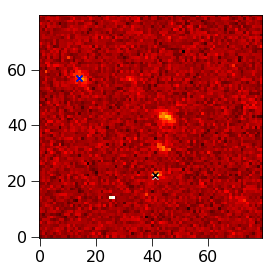

In [20]:
im = plt.imshow(partimg, cmap='hot')
#plt.clim(1800, 2800)
plt.scatter(targcen[1], targcen[0], c='w', marker='x')
plt.scatter(compcen[1], compcen[0], c='g', marker='x')
plt.scatter(tcenter[1], tcenter[0], c='k', marker='x')
plt.scatter(ccenter[1], ccenter[0], c='b', marker='x')
plt.show()

b. Disply image with aperture mask and sky annulus

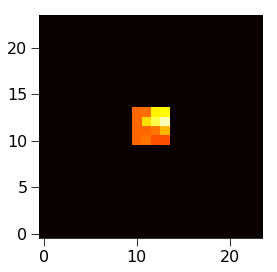

In [21]:
im = plt.imshow(targaper, cmap='hot')
plt.clim(1800, 2800)
plt.show()

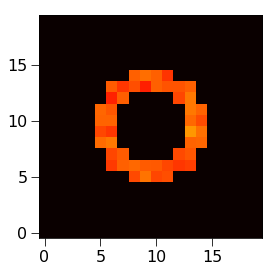

In [22]:
im = plt.imshow(targann, cmap='hot')
plt.clim(1800, 2800)
plt.show()

### 1.4 PSF models

[code here for Gaussian PSF model]

## 2. Photometry

### 2.1 Calculate SNR

Calculate Signal-to-Noise Ratio. CCD noise = sqrt(signal + background + dark current + read noise) 

In [23]:
def calcsnr(target, bg):
    signal = target - bg
    noise = np.sqrt(signal + bg)
    snr = signal / noise
    return snr, noise   

In [24]:
sumtargc = np.sum(circle(searchr*2, ap_r))
sumtarga = np.sum(annulus(searchr*2, sky_inner, sky_outer))
sumcompc = np.sum(circle(searchr*2, ap_r))
sumcompa = np.sum(annulus(searchr*2, sky_inner, sky_outer))

targc = np.sum(targaper) / sumtargc
targbg= np.sum(targann) / sumtarga
compc = np.sum(compaper) / sumcompc
compbg= np.sum(compcen) / sumcompa

In [25]:
snr, noise = calcsnr(targc, targbg)
print (snr)

2.29780378589


### 2.2 Optimize photometry aperture

In [26]:
#Try a range of aperture sizes
apertures = np.arange(1, 10, 1)

snrold = 0
for aper in apertures:
    apermask = circle(searchr*2, ap_r)
    targc = np.sum(apermask*newtarg) / np.sum(apermask)
    snr, noise = calcsnr(targc, targbg)
    if snr > snrold:
        bestaper = aper
        snrold = snr

### 2.3 Calculate target's magnitude


In [27]:
targc = circle(searchr*2, ap_r)*newtarg
targskyc = annulus(searchr*2, sky_inner, sky_outer)*newtarg
compc = circle(searchr*2, ap_r)*newcomp
compskyc = annulus(searchr*2, sky_inner, sky_outer)*newcomp

ratio = np.sum(compc)/np.sum(targc)
sigmaratio = ratio*np.sqrt((np.sum(targc)/np.sum(targskyc))**2 + (np.sum(compc)/np.sum(compc))**2)

deltamag = -2.5*np.log10(ratio)
sigmamag = 2.5*sigmaratio/(ratio*np.log(10))

refmag = 20.4
mag = refmag - deltamag
print("Measured Magnitude = {:0.3f} ± {:0.3f}".format(mag, sigmamag))

Measured Magnitude = 20.340 ± 1.150
